In [1]:
#@title Run this cell to setup visualization...
# This cell defines plot_progress() which plots an optimization trace.

import matplotlib
from matplotlib import pyplot as plt

def plot_progress(bowl, track, losses):
    # Draw the contours of the objective function, and x, and y
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 5))
    for size in torch.linspace(0.1, 1.0, 10):
        angle = torch.linspace(0, 6.3, 100)
        circle = torch.stack([angle.sin(), angle.cos()])
        ellipse = torch.mm(torch.inverse(bowl), circle) * size
        ax1.plot(ellipse[0,:], ellipse[1,:], color='skyblue')
    track = torch.stack(track).t()
    ax1.set_title('progress of x')
    ax1.plot(track[0,:], track[1,:], marker='o')
    ax1.set_ylim(-1, 1)
    ax1.set_xlim(-1.6, 1.6)
    ax1.set_ylabel('x[1]')
    ax1.set_xlabel('x[0]')
    ax2.set_title('progress of y')
    ax2.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))
    ax2.plot(range(len(losses)), losses, marker='o')
    ax2.set_ylabel('objective')
    ax2.set_xlabel('iteration')
    fig.show()

from IPython.display import HTML
HTML('''<script>function toggle_code(){$('.rendered.selected div.input').toggle().find('textarea').focus();} $(toggle_code())</script>
<a href="javascript:toggle_code()">Toggle</a> the code for plot_progress.''')

Pytorch Optimizers
==================

Optimizers have a simple job: given gradients of an objective with respect to a set of input parameters, adjust the parameters reduce the objective.  They do this by modifying each parameter by a small amount in the direction given by the gradient.


Gradient descent just subtracts the gradient
---------
You can apply gradient descent by hand easily by just using `loss.backward()` to compute the gradient of the loss with respect to every parameter `x`, and then apply `x -= learning_rate * x.grad` to nudge `x` in the gradient direction that makes the loss smaller.

Here is an example of applying gradient descent by hand:

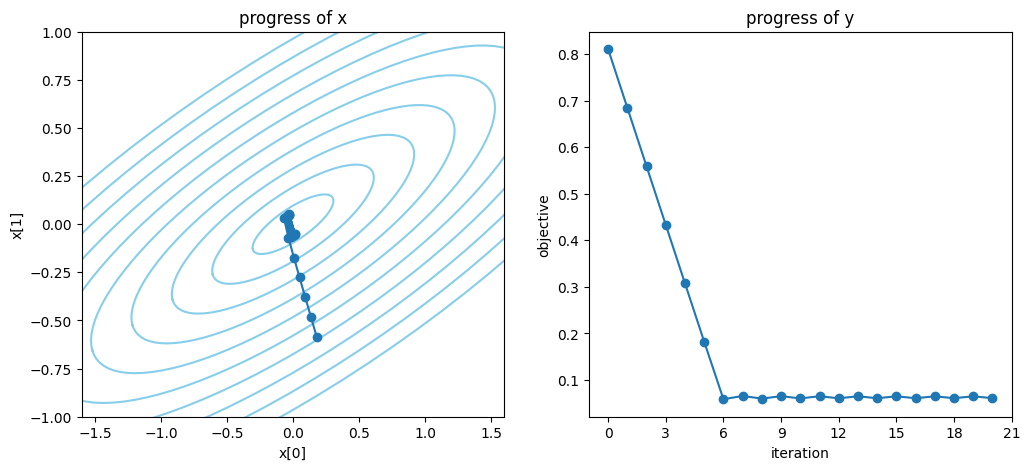

In [4]:
import torch

x_init = torch.randn(2)
x = x_init.clone()

bowl = torch.tensor([[ 0.4410, -1.0317], [-0.2844, -0.1035]])
track, losses = [], []

for iter in range(21):
    x.requires_grad = True
    loss = torch.mm(bowl, x[:,None]).norm()
    loss.backward()
    with torch.no_grad():
        x = x - 0.1 * x.grad
    track.append(x.detach().clone())
    losses.append(loss.detach())

plot_progress(bowl, track, losses)

Built-in optimization algorithms
------

Pytorch includes several optimization algorithms.

The actual optmization algorithms employ a number of techniques to make the process faster and more robust as repeated steps are taken, by trying to adapt to the shape of the objective surface as it is explored.  The simplest method is SGD-with-momentum, which is implemented in pytorch as `pytorch.optim.SGD`.

Using SGD
---------

To use SGD, you need to calculate your objective and fill in gradients on all the parameters before it can take a step.

  1. Set your parameters (x in this case) to `x.requires_grad = True` so autograd tracks them (line 5).
  2. Create the optimizer and tell it about the parameters to adjust (`[x]` here) (line 6).
  3. In a loop, compute your objective, then call `loss.backward()` to fill in `x.grad` and then `optimizer.step()` to adjust `x` accordingly (lines 12-15).
  
**Remember to zero gradient.** Notice that we use `optimizer.zero_grad()` each time to set x.grad to zero before recomputing gradients; if we do not do this, then the new gradient will be added to the old one.


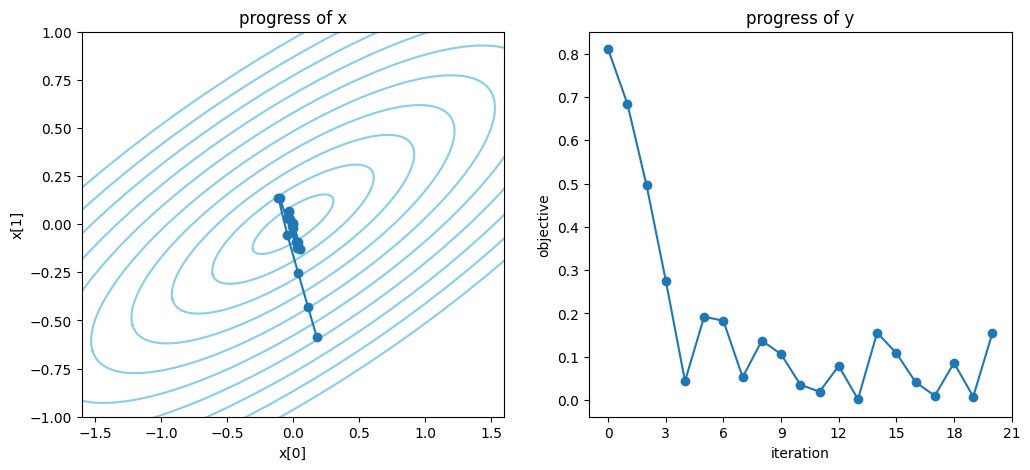

In [5]:
import torch

x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.SGD([x], lr=0.1, momentum=0.5)

bowl = torch.tensor([[ 0.4410, -1.0317], [-0.2844, -0.1035]])
track, losses = [], []

for iter in range(21):
    loss = torch.mm(bowl, x[:,None]).norm()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    track.append(x.detach().clone())
    losses.append(loss.detach())

plot_progress(bowl, track, losses)

### Exercise

1. Set the `x_init` fixed, to the point `torch.tensor([-1.0, 0.0])`.
2. Increase the number of iterations to 101.
3. Experiment with different combinations of `lr` and `momentum` to see which converges to zero `y` best.

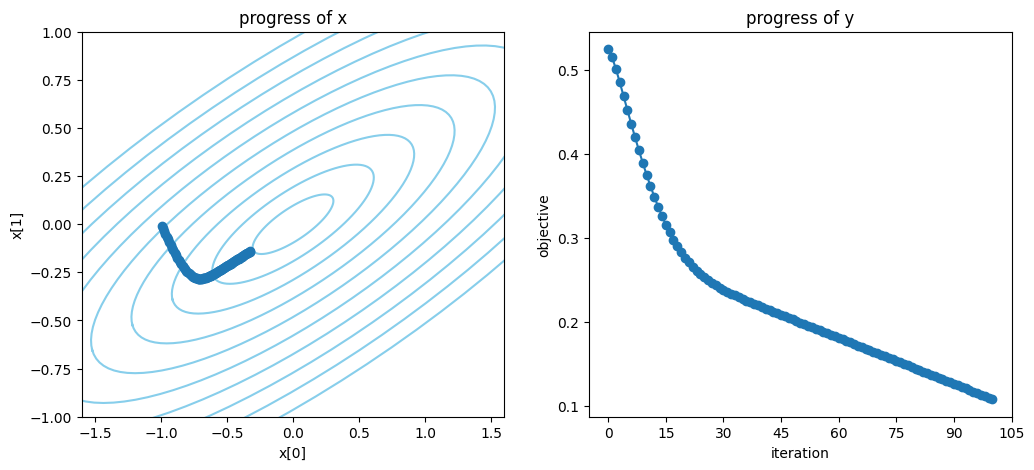

In [16]:
# TODO: Copy the SGD cell above, and modify it to
# 1. set x_init to [-1, 0]

# 2. Increase iterations to 101

# 3. Find settings for lr and momenum that get the lowest objective

x = torch.tensor([-1.0, 0.0])
x.requires_grad = True
optimizer = torch.optim.SGD([x], lr=0.01, momentum=0.5)

bowl = torch.tensor([[ 0.4410, -1.0317], [-0.2844, -0.1035]])
track, losses = [], []

for iter in range(101):
    loss = torch.mm(bowl, x[:,None]).norm()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    track.append(x.detach().clone())
    losses.append(loss.detach())

plot_progress(bowl, track, losses)

Using other optimizers
----------------------

Other optimizers are similar.  Adam is a popular adaptive method that does well without much tuning, and can be dropped in to replace plain SGD.

Some other fancy optimizers, such as LBFGS, need to be given an objective function that they can call repeatedly to probe gradients themselves.  Examples can be found elsewhere: for example [hjmshi's LBFGS includes some examples](https://github.com/hjmshi/PyTorch-LBFGS/blob/master/examples/Other/lbfgs_tests.py#L129-L132).

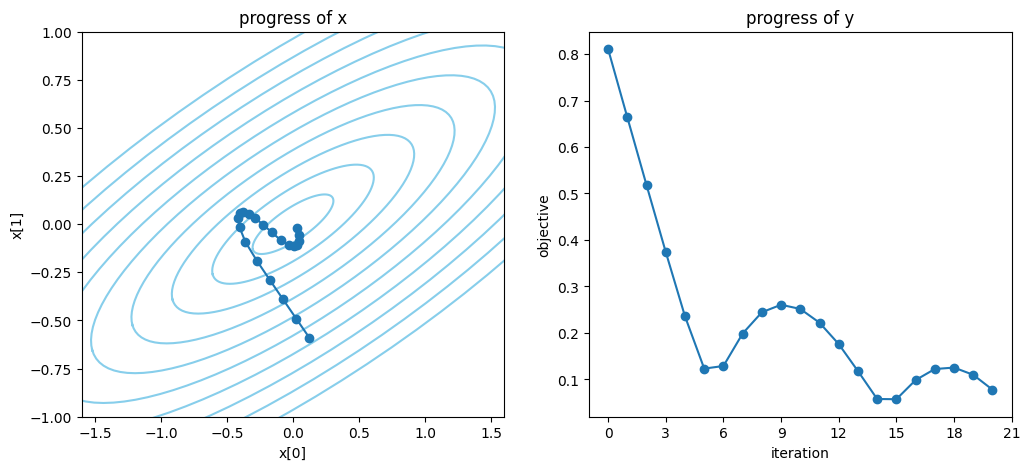

In [17]:
# The code below uses Adam
x = x_init.clone()
x.requires_grad = True
optimizer = torch.optim.Adam([x], lr=0.1)

track, losses = [], []

for iter in range(21):
    loss = torch.mm(bowl, x[:,None]).norm()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    track.append(x.detach().clone())
    losses.append(loss.detach())

plot_progress(bowl, track, losses)

### Exercise

We will try the LBFGS optimizer.

1. To start, as in the first exercise, set `x_init` to `torch.tensor([-1.0, 0.0])` and increase to 101 iterations.
2. Define a zero-argument function for the loss, e.g.: `loss = lambda: torch.mm(bowl, x[:,None]).norm()`
3. Use `torch.optim.LBFGS` as the optimizer, setting the option `max_eval=5`.  Since this optimizer probes the loss several different points for each step, `optimizer.step` requires the `loss` function as an argument now.
4. Experiment with different learning rates and `max_eval` values.

Note that LBFGS is a very memory-intensive optimizer, too expensive for training most neural networks.  But for a small parameter set it is great.



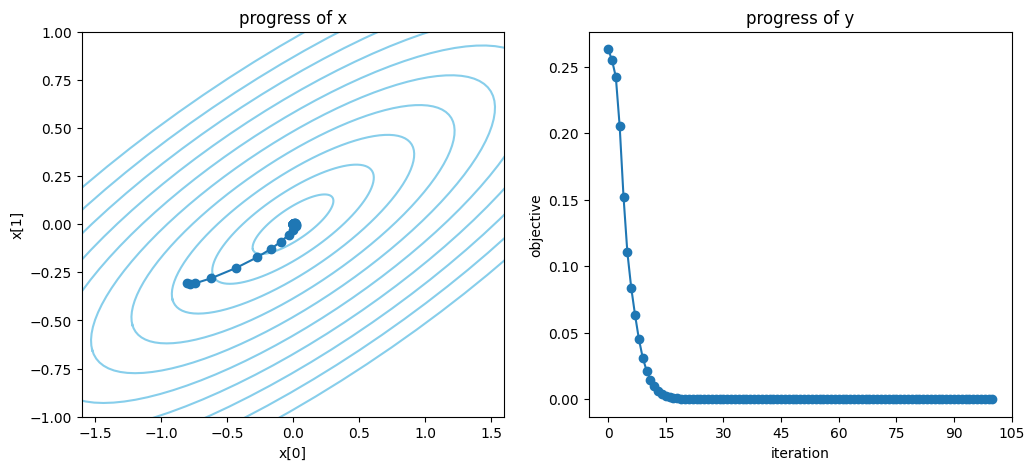

In [21]:
# TODO: Copy the SGD cell above, and modify it to
# 1. set x_init to [-1, 0] and increase iterations to 101
# 2. define a zero-argument `loss` function
# 3. use LBFGS instead of SGD.  Pay attention to the `loss` argument of `optimizer.step()`
# 4. experiment with LBFGS settings.

x = torch.tensor([-1.0, 0.0])
x.requires_grad = True
optimizer = torch.optim.LBFGS([x], lr=0.1, max_eval=5)

track, losses = [], []

for iter in range(101):
    optimizer.zero_grad()
    loss = lambda: torch.mm(bowl, x[:,None]).norm()
    loss().backward()
    optimizer.step(loss)
    track.append(x.detach().clone())
    losses.append(loss().detach())

plot_progress(bowl, track, losses)

Other tricks
------------------------

 1. **Learning rate schedules**.  One of the simplest and most effective ways to improve training is to adjust the learning rate, decreasing it during training.   There are many differerent strategies for scheduling learning rates, and pytorch comes with a set of `torch.optim.lr_scheduler` classes to make it easy to drop in a variety of methods.  See [Stack overflow](https://stackoverflow.com/questions/48324152/) or [scheduler documentation](https://pytorch.org/docs/stable/optim.html#torch.optim.lr_scheduler.StepLR).
 2. **Multiple optimizers**. Sometimes you want to optimize more than one objective.  The ordinary solution to this is to make an single overall objective as a (weighted) sum of all the objectives.  However, sometimes you want to apply one objective to some parameters and a different objective to a different set of parameters.  This occurs, for example in *adversarial training* such as in GANs, where two networks are learning to play against each other.  In this case you can use multiple different optimizers, one for each opposing objective.  See [Examples of GAN implementations](https://github.com/eriklindernoren/PyTorch-GAN/blob/master/implementations/gan/gan.py#L112-L113) to see how this is done.

### [On to topic 4: Modules &rightarrow;](4-Pytorch-Modules.ipynb)